In [1]:
import env
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt

from dqn_agent import Agent
from collections import deque

In [2]:
NUM_AGENTS = 16
ACTION_SIZE = 8
STATE_SIZE = (84, 84, 1)

In [3]:
environment = env.Environment("bevystein.exe", (STATE_SIZE[0], STATE_SIZE[1]), NUM_AGENTS)

In [4]:
from model import VisualQNetwork

agent = Agent(
    state_size=STATE_SIZE, 
    action_size=ACTION_SIZE, 
    seed=0, 
    double=True, 
    priority_replay=False,
    q_network=VisualQNetwork,
)

In [5]:
def augment_state(frames, actions):
    action_t_minus_1, action_t = actions[-1], actions[0]
    pix_t_minus_1, pix_t, pix_t_plus_1  = frames[0], frames[1], frames[2]

    action_t_minus_1 = np.ones((STATE_SIZE[0], STATE_SIZE[1])) * action_t_minus_1
    action_t = np.ones((STATE_SIZE[0], STATE_SIZE[1])) * action_t
           
    state = np.stack([
        pix_t_minus_1, 
        pix_t,
        pix_t_plus_1,
    ])
    
    return state

def dqn(n_episodes=100, max_t=10000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    
    scores = []                          # list containing scores from each episode
    scores_window = deque(maxlen=max_t)  # last 100 scores
    eps = eps_start                      # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):

        state, _ = environment.reset()
        
        framebuffers = []
        action_buffers = []

        # get initial 3-frame observation
        for i in range(NUM_AGENTS):
            framebuffer = deque(maxlen=3)
            action_buffer = deque(maxlen=2)

            for _ in range(0, 3):
                framebuffer.append(state[i])
            for _ in range(0, 2):
                action_buffer.append(np.ones(1))            
            
            framebuffers.append(framebuffer)
            action_buffers.append(action_buffer)
        
        state = []
        for i in range(0, NUM_AGENTS):
            agent_state = augment_state(list(framebuffers[i]), list(action_buffers[i]))
            state.append(agent_state)
        state = np.array(state)

        agent_scores = [0 for i in range(NUM_AGENTS)]
        for t in range(max_t):

            actions = []
            raw_actions = []
            rewards = []
            is_terminated = []
            for i in range(0, NUM_AGENTS):
                action = agent.act(state[i], eps).astype(int)
                action_buffers[i].append(action)
                actions.append(action)
                raw_actions.append(int(action))
            
            screens, rewards, is_terminated, _, _ = environment.step(actions)
            for i in range(0, NUM_AGENTS):
                framebuffers[i].append(screens[i])
                next_state = augment_state(list(framebuffers[i]), list(action_buffers[i]))
                agent.step(state[i], raw_actions[i], float(rewards[i]), next_state, int(is_terminated[i]))
                state[i] = next_state
                agent_scores[i] += rewards[i]
                if is_terminated[i]: continue 

            if np.all(is_terminated):
                break

        scores_window.append(np.max(agent_scores))       # save most recent score
        scores.append(np.max(agent_scores))
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            torch.save(agent.qnetwork_local.state_dict(), "visual_q_network.pth")
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    return scores

In [6]:
scores = dqn(n_episodes=100, max_t=100)

Episode 100	Average Score: 15.80


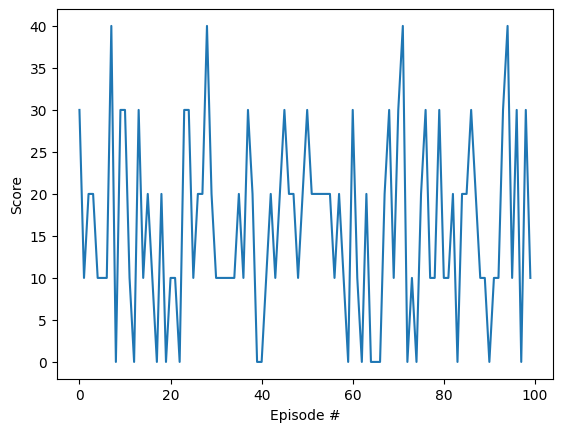

In [7]:
fig = plt.figure()
fig.add_subplot(111)

plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()